This notebook explains the scheme for sampling the DOF perturbations.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from donut_sims.dofsToZernikes import dofsToZernikes
from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import convertZernikesToPsfWidth


The values of $\Delta\!$ PSF / $\Delta\!$ DOF were already determined in another notebook. Here they are:

In [41]:
dPSF_dDOF = np.array(
    [
        1.149e-02,  # 0
        6.445e-04,
        6.445e-04,
        2.057e-02,
        2.057e-02,
        1.192e-02,  # 5
        1.700e-04,
        1.700e-04,
        1.408e-02,
        1.408e-02,
        8.362e-01,  # 10
        8.363e-01,
        2.450e00,
        1.131e00,
        1.154e00,
        2.471e00,  # 15
        2.488e00,
        1.396e00,
        1.412e00,
        1.487e00,
        1.461e00,  # 20
        1.088e00,
        1.800e00,
        1.794e00,
        1.469e00,
        1.425e00,  # 25
        1.818e00,
        1.854e00,
        6.823e-01,
        1.375e00,
        5.474e-01,  # 30
        5.474e-01,
        8.107e-01,
        8.361e-01,
        1.140e00,
        1.286e00,  # 35
        1.286e00,
        1.066e00,
        1.047e00,
        1.423e00,
        1.431e00,  # 40
        1.318e00,
        1.318e00,
        1.726e00,
        1.781e00,
        7.234e-01,  # 45
        6.391e-01,
        2.610e00,
        2.324e00,
        2.325e00,  # 49
    ]
)


We determine the total PSF perturbation by sampling from a folded Gaussian distribution, then determine the PSF perturbation allotted to each DOF by sampling from the hypersphere with the corresponding radius. Finally, we use the conversion factors above to convert these PSF perturbations to DOF perturbations.

In practice, we sample a radius, then sample from the 50 dimensional unit Normal to determine a direction vector, then normalize that vector so it has the desired norm (i.e. project it onto the sphere of the desired radius).

Note the radii are drawn from a folded Gaussian distribution, with $\mu = \sigma$, and $\mu$ is chosen so that the expectation value is 0.3. The PDF of this distribution is
$$
\frac{1}{\sqrt{2\pi \mu^2}} \left[ 
    e^{-\frac{1}{2} \left( \frac{x}{\mu} - 1 \right)^2} +
    e^{-\frac{1}{2} \left( \frac{x}{\mu} + 1 \right)^2}
\right],
$$
and $\mu$ is determined analytically from the mean, $\bar{x}$:
$$
    \mu = \bar{x} \cdot \left[ 
    \sqrt{\frac{2}{\pi}} \, e^{-\frac{1}{2}} + 
    \mathrm{erf} \! \left( \frac{1}{\sqrt{2}} \right) 
\right]^{-1}.
$$

In [42]:
rng = np.random.default_rng(0)

size = 1_000

# draw random radii
mean = 0.3  # set the mean radius
mu = mean / (np.sqrt(2 / np.pi) * np.exp(-1 / 2) + erf(1 / np.sqrt(2)))
radii = np.abs(rng.normal(mu, mu, size=(size, 1)))

# sample from unit normal to determine direction vectors
dPSF = rng.normal(size=(size, 50))

# project direction vectors onto the hyperspheres with random radii
dPSF *= radii / np.sqrt(np.square(dPSF).sum(axis=1, keepdims=True))

# convert PSF perturbations to DOF perturbations
dDOF = dPSF / dPSF_dDOF


In [52]:
psf_degradations = []

for dof in dDOF:
    for corner in ["R00", "R40", "R44", "R04"]:
        zk = dofsToZernikes(dof, corner, subtract_zk0=True)
        psf_degradations.append(np.sqrt(np.sum(zk**2)))

psf_degradations = np.array(psf_degradations)


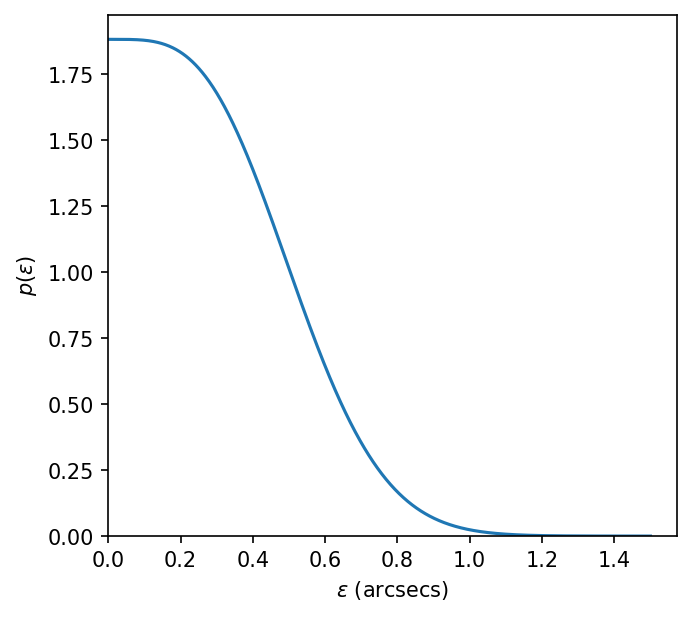

In [66]:
fig, ax = plt.subplots(figsize=(4.5, 4), dpi=150, constrained_layout=True)

x = np.linspace(0, 1.5, 1000)
ax.plot(
    x,
    (np.exp(-((x / mu - 1) ** 2) / 2) + np.exp(-((x / mu + 1) ** 2) / 2))
    / np.sqrt(2 * np.pi * mu**2),
    label="generating distribution",
)

ax.set(
    xlabel="$\\varepsilon$ (arcsecs)",
    ylabel="$p(\\varepsilon)$",
    xlim=(0, None),
    ylim=(0, None),
)

fig.savefig("figures/psf_distribution.pdf")

plt.show()


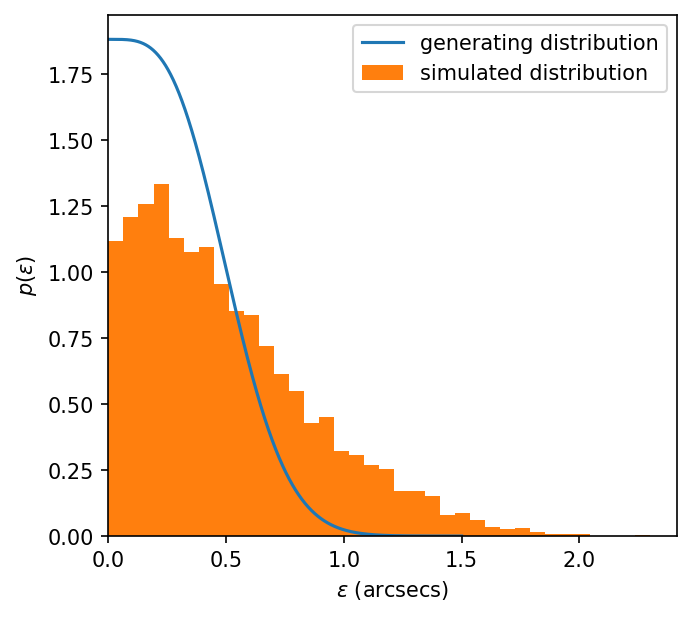

In [67]:
fig, ax = plt.subplots(figsize=(4.5, 4), dpi=150, constrained_layout=True)

x = np.linspace(0, 1.5, 1000)
ax.plot(
    x,
    (np.exp(-((x / mu - 1) ** 2) / 2) + np.exp(-((x / mu + 1) ** 2) / 2))
    / np.sqrt(2 * np.pi * mu**2),
    label="generating distribution",
)

ax.hist(psf_degradations, bins="auto", density=True, label="simulated distribution")

ax.legend()

ax.set(
    xlabel="$\\varepsilon$ (arcsecs)",
    ylabel="$p(\\varepsilon)$",
    xlim=(0, None),
    ylim=(0, None),
)

fig.savefig("figures/psf_distribution_w_empirical.pdf")

plt.show()
